# Importation des bibliotheques

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D ,BatchNormalization
from keras.optimizers import Adam , RMSprop , SGD
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from google.colab import drive 
import pandas as pd
%matplotlib inline
tf.__version__

'2.4.0'

Connexion au Drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#le chemin du dossier 'data' qui contient deux dossiers , 'train' et 'test'
data_path='/content/drive/MyDrive/datasetskin/data'

In [4]:
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

In [5]:
# utile pour obtenir le nombre de classes
folders = glob(train_dir+'/*')

# Augmentation

ImageDataGenerator() est une technique d’application de différentes transformations aux images originales qui se traduit par de multiples copies transformées de la même image. Chaque copie, cependant, est différente de l’autre dans certains aspects en fonction des techniques d’augmentation que vous appliquez comme le déplacement, la rotation, le retournement, etc.

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#on a fixé le batch_size à 64 pour les images d'entrenement et du test.
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [7]:
#Tailles des images
IMG_SHAPE = (224, 224,3)

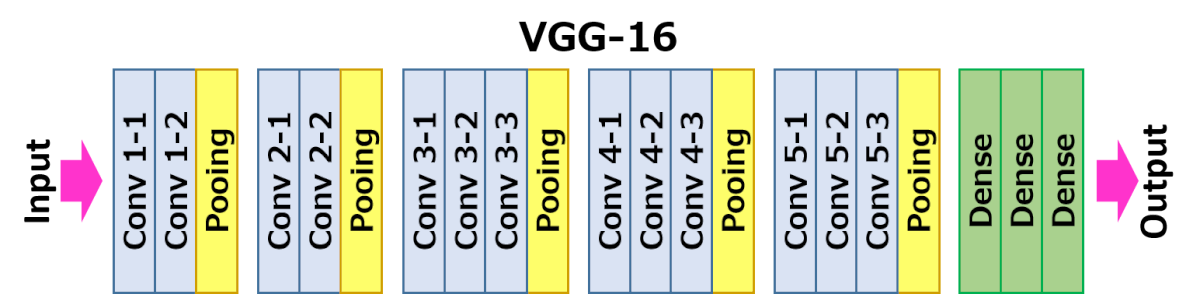

VGG16 est un modèle de réseau neuronal convolutionnel proposé par K. Simonyan et A. Zisserman de l’Université d’Oxford dans l’article « Very Deep Convolutional Networks for Large-Scale Image Recognition ». Le modèle atteint 92,7% de précision de test top-5 dans ImageNet, qui est un ensemble de données de plus de 14 millions d’images appartenant à 1000 classes. C’était l’un des fameux modèles soumis à l’ILSVRC-2014. Il améliore AlexNet en remplaçant les grands filtres de taille noyau (11 et 5 dans la première et la deuxième couche convolutionnelle, respectivement) par de multiples filtres de taille noyau 3 3 l’un après l’autre.

In [8]:
#Faire appel au model pre-definie VGG16
VGG16_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Freezing

In [9]:
VGG16_model.trainable = False

In [10]:
#ajout des couches
x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(len(folders), activation='softmax')(x)

In [11]:
model = Model(inputs=VGG16_model.input, outputs=predictions)

In [12]:
model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001), metrics=['accuracy'])

In [13]:
#Réduire le taux d’apprentissage lorsqu’une mesure cesse de s’améliorer.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
history_VGG=model.fit(training_set, epochs=50, validation_data=test_set, callbacks=[learning_rate_reduction])

Epoch 1/50
42/42 [==============================] - 47s 989ms/step - loss: 0.7076 - accuracy: 0.5638 - val_loss: 0.5732 - val_accuracy: 0.7348
Epoch 2/50
42/42 [==============================] - 41s 963ms/step - loss: 0.5708 - accuracy: 0.7374 - val_loss: 0.4816 - val_accuracy: 0.7970
Epoch 3/50
42/42 [==============================] - 40s 954ms/step - loss: 0.4960 - accuracy: 0.7871 - val_loss: 0.4415 - val_accuracy: 0.8152
Epoch 4/50
42/42 [==============================] - 40s 951ms/step - loss: 0.4637 - accuracy: 0.7984 - val_loss: 0.4139 - val_accuracy: 0.8167
Epoch 5/50
42/42 [==============================] - 39s 933ms/step - loss: 0.4101 - accuracy: 0.8270 - val_loss: 0.4047 - val_accuracy: 0.8288
Epoch 6/50
42/42 [==============================] - 39s 930ms/step - loss: 0.4241 - accuracy: 0.8170 - val_loss: 0.3952 - val_accuracy: 0.8212
Epoch 7/50
42/42 [==============================] - 40s 946ms/step - loss: 0.4086 - accuracy: 0.8150 - val_loss: 0.3875 - val_accuracy: 0.8288

# Plot

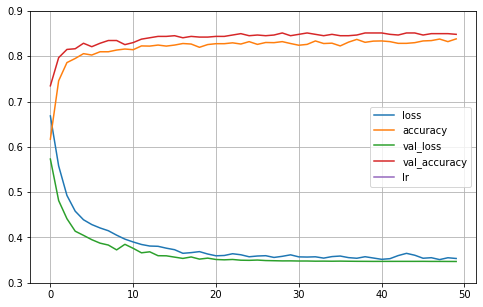

In [15]:
#affichage des resultats
pd.DataFrame(history_VGG.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.9)
plt.show()

Fine-tuning

In [16]:
#unfreeze
VGG16_model.trainable = True

In [17]:
model.compile(  loss='binary_crossentropy',
  optimizer= SGD(lr=0.00001, momentum=0.9),
  metrics=['accuracy'])

In [18]:
#entrainemt apres unfreeze
fine_tuning = model.fit(training_set, epochs=25, validation_data=test_set,callbacks=[learning_rate_reduction])

Epoch 1/25
42/42 [==============================] - 53s 1s/step - loss: 0.3704 - accuracy: 0.8254 - val_loss: 0.3419 - val_accuracy: 0.8439
Epoch 2/25
42/42 [==============================] - 48s 1s/step - loss: 0.3366 - accuracy: 0.8420 - val_loss: 0.3361 - val_accuracy: 0.8500
Epoch 3/25
42/42 [==============================] - 49s 1s/step - loss: 0.3500 - accuracy: 0.8329 - val_loss: 0.3340 - val_accuracy: 0.8500
Epoch 4/25
42/42 [==============================] - 49s 1s/step - loss: 0.3434 - accuracy: 0.8452 - val_loss: 0.3381 - val_accuracy: 0.8455
Epoch 5/25
42/42 [==============================] - 49s 1s/step - loss: 0.3273 - accuracy: 0.8399 - val_loss: 0.3307 - val_accuracy: 0.8515
Epoch 6/25
42/42 [==============================] - 48s 1s/step - loss: 0.3515 - accuracy: 0.8327 - val_loss: 0.3282 - val_accuracy: 0.8500
Epoch 7/25
42/42 [==============================] - 48s 1s/step - loss: 0.3280 - accuracy: 0.8477 - val_loss: 0.3291 - val_accuracy: 0.8485
Epoch 8/25
42/42 [==

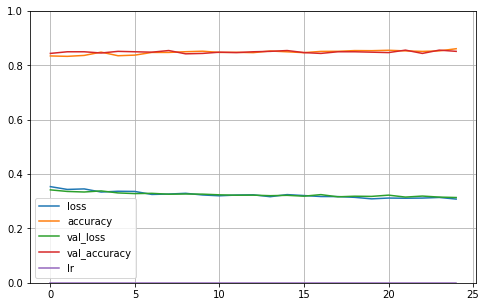

In [21]:
pd.DataFrame(fine_tuning.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

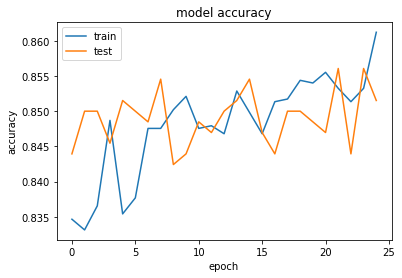

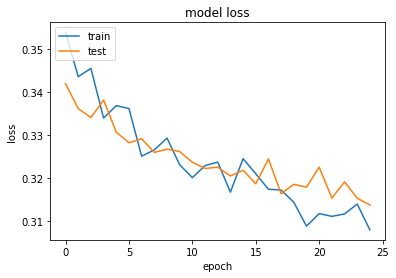

In [20]:
# summarize history for accuracy
plt.plot(fine_tuning.history['accuracy'])
plt.plot(fine_tuning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fine_tuning.history['loss'])
plt.plot(fine_tuning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()